In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def perspective_warp(img):
    
    img_size = np.float32([(img.shape[1],img.shape[0])])
    dst_size=(1280,720)
    
    # src: Coordinates of quadrangle vertices in the source image
    src = np.float32([(0.5,0.60),(0.75,0.60),(0.1,1),(1,1)])
    src = src* img_size

    # dst - Coordinates of the corresponding quadrangle vertices in the destination image.
    dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])    
    dst = dst * np.float32(dst_size)  
    
    # perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    
    return warped

In [3]:
def inv_perspective_warp(img):
    
    img_size = np.float32([(img.shape[1],img.shape[0])])
    dst_size=(1280,720)
    
    # src: Coordinates of quadrangle vertices in the source image
    src = np.float32([(0,0), (1, 0), (0,1), (1,1)])    
    src = src * np.float32(dst_size) 

    # dst - Coordinates of the corresponding quadrangle vertices in the destination image.
    dst = np.float32([(0.5,0.60),(0.75,0.60),(0.1,1),(1,1)])
    dst = dst* img_size 
    
    # perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    
    return warped

In [4]:
def combined_binary_threshold(warped_img, thresh = (200, 255), sob_thresh = (5, 255)):
    
    # Convert to HLS/HSV color space and separate the V channel and L channel
    hls = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HSV)
    
    h, l, s = cv2.split(hls)
    v = hsv[:, :, 2]

    canny = cv2.Canny(l, 50, 150)
    canny_binary = np.zeros_like(canny)
    
    sobel_l = cv2.Sobel(l, cv2.CV_64F, 1, 1)
    scaled_sobel_l = cv2.convertScaleAbs(sobel_l)
    sobel_binary = np.zeros_like(scaled_sobel_l)
    sobel_binary[(scaled_sobel_l >= sob_thresh[0]) & (scaled_sobel_l <= sob_thresh[1])] = 1
    
    # Threshold l channel
    l_binary = np.zeros_like(l)
    l_binary[(l >= thresh[0]) & (l <= thresh[1])] = 1

    # Threshold v channel
    v_binary = np.zeros_like(v)
    v_binary[(v > thresh[0]) & (v < thresh[1])] = 1
    
    #Combined Binary
    combined_binary = np.zeros_like(s)
    combined_binary[(l_binary == 1) | (v_binary == 1) | (sobel_binary == 1)] = 1
    
    return combined_binary


In [5]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

In [6]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows = 15, margin = 200,  minpix = 1, draw_windows=True):
    
    global left_a, left_b, left_c, right_a, right_b, right_c
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255
    
    histogram = get_hist(img)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print('midpoint, leftx_base, rightx_base', midpoint, leftx_base, rightx_base)
    #plt.plot(histogram)
    #plt.show()
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    window_height = np.int(img.shape[0]/nwindows)
    
    for window in range(nwindows):
        
        # Window boundaries
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (100,255,255), 3) 
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (100,255,255), 3) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]
    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

In [7]:
def get_curve(img, leftx, rightx):
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.75/720 #3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

## EDA

Text(0.5, 1.0, 'Frame 1000')

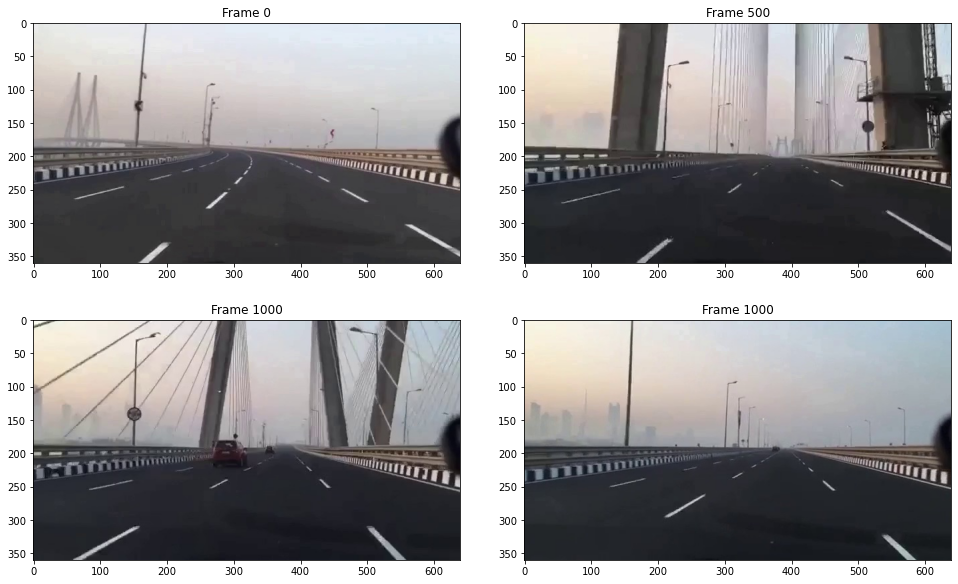

In [8]:
# reading images
Image1 = cv2.imread('0.jpg')
Image2 = cv2.imread('500.jpg')
Image3 = cv2.imread('1000.jpg')
Image4 = cv2.imread('1200.jpg')

# create figure
fig = plt.figure(figsize = (15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure = fig, left=0.1, bottom=0.25, right=0.95, top=0.80,
        wspace=0.15, hspace=0., width_ratios=[1, 1])

Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
ax1 = plt.subplot(gs[0])
ax1.imshow(Image1)
ax1.set_title('Frame 0')

Image2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
ax2 = plt.subplot(gs[1])
ax2.imshow(Image2)
ax2.set_title('Frame 500')

Image3 = cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB)
ax3 = plt.subplot(gs[2])
ax3.imshow(Image3)
ax3.set_title('Frame 1000')

Image4 = cv2.cvtColor(Image4, cv2.COLOR_BGR2RGB)
ax4 = plt.subplot(gs[3])
ax4.imshow(Image4)
ax4.set_title('Frame 1000')

In [9]:
def draw_lanes(img, left_fit, right_fit):
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    
    return inv_perspective

### STEP 1 - CAPTURE AND DECODE IMAGE

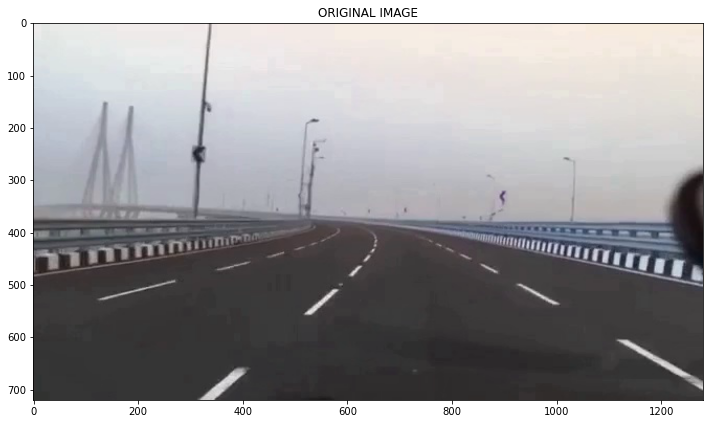

In [10]:
test = cv2.imread('0.jpg') #585, 1065
rgb = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
rgb = cv2.resize(test, (1280, 720), interpolation=cv2.INTER_AREA)

ln_img = np.copy(rgb)

plt.figure(figsize = (12, 12))
plt.imshow(ln_img)
plt.title('ORIGINAL IMAGE')
plt.show()

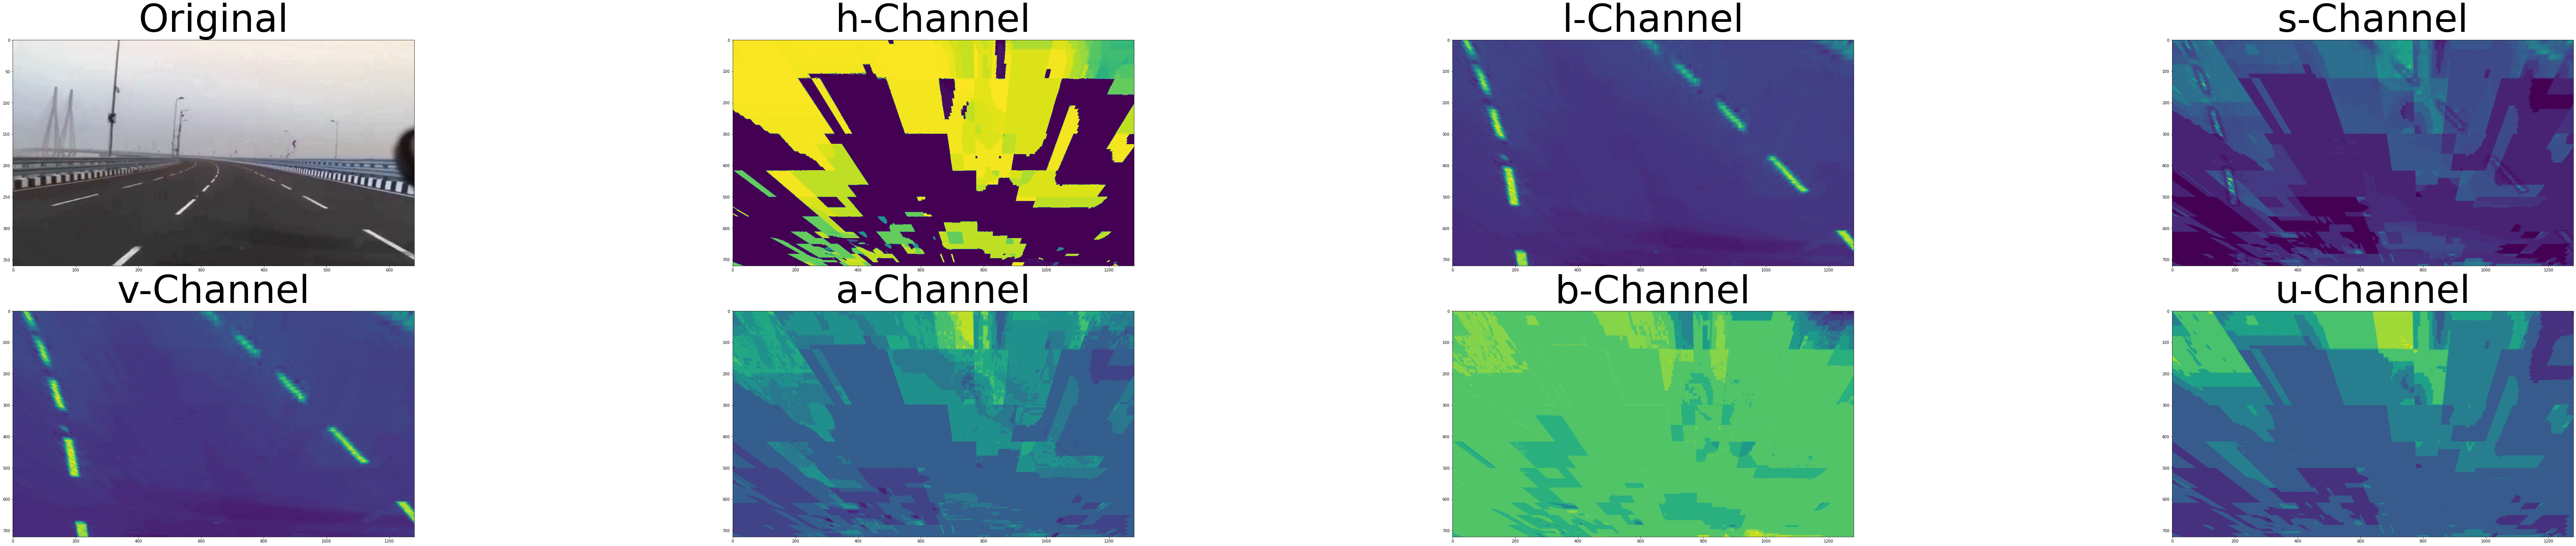

In [11]:
warped = perspective_warp(ln_img)

hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(warped, cv2.COLOR_RGB2LAB)
luv = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)

h, l, s = cv2.split(hls)
v = hsv[:, :, 2]
a = lab[:, :, 1]
b = lab[:, :, 2]
u = luv[:, :, 1]

f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(test)
ax1.set_title('Original', fontsize=100)
ax2.imshow(h)
ax2.set_title('h-Channel', fontsize=100)
ax3.imshow(l)
ax3.set_title('l-Channel', fontsize=100)
ax4.imshow(s)
ax4.set_title('s-Channel', fontsize=100)
ax5.imshow(v)
ax5.set_title('v-Channel', fontsize=100)
ax6.imshow(a)
ax6.set_title('a-Channel', fontsize=100)
ax7.imshow(b)
ax7.set_title('b-Channel', fontsize=100)
ax8.imshow(u)
ax8.set_title('u-Channel', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

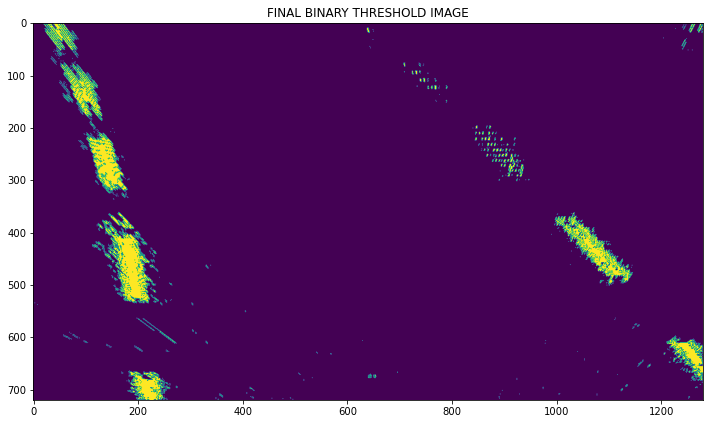

In [12]:
combined = combined_binary_threshold(warped)

plt.figure(figsize = (12, 12))
plt.imshow(combined)
plt.title('FINAL BINARY THRESHOLD IMAGE')
plt.show()

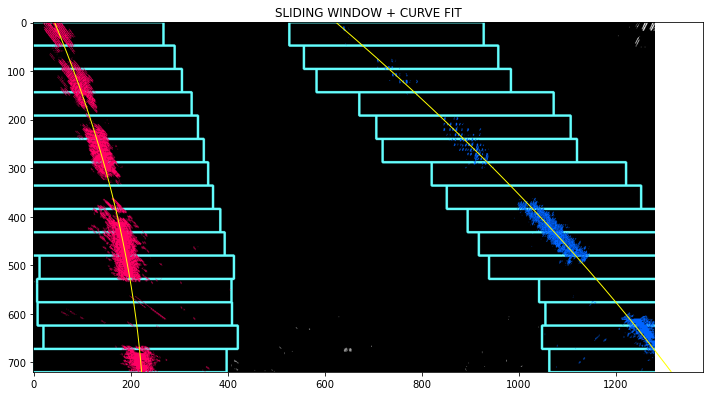

(2, 720)


In [13]:
out_img, curves, lanes, ploty = sliding_window(combined)

plt.figure(figsize = (12, 12))
plt.imshow(out_img)
plt.plot(curves[0], ploty, color='yellow', linewidth=1)
plt.plot(curves[1], ploty, color='yellow', linewidth=1)
plt.title('SLIDING WINDOW + CURVE FIT')
plt.show()

print(np.asarray(curves).shape)

(736.0379573326567, 615.8327754252851, 0.49874697938338974)


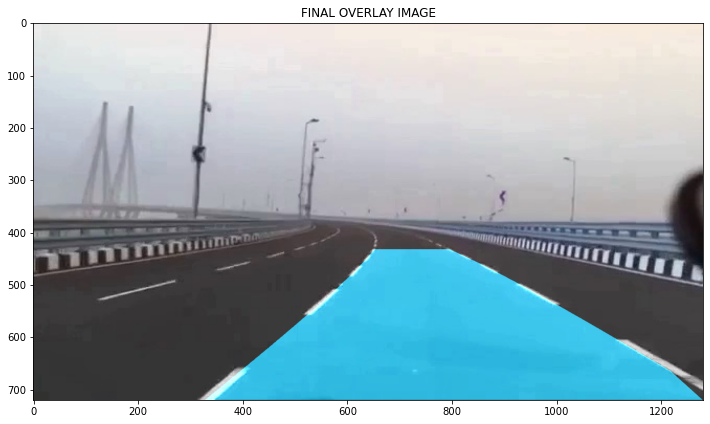

In [14]:
curverad=get_curve(ln_img, curves[0],curves[1])
print(curverad)
img_ = draw_lanes(ln_img, curves[0], curves[1])

plt.figure(figsize = (12, 12))
plt.imshow(img_, cmap='hsv')
plt.title('FINAL OVERLAY IMAGE')
plt.show()

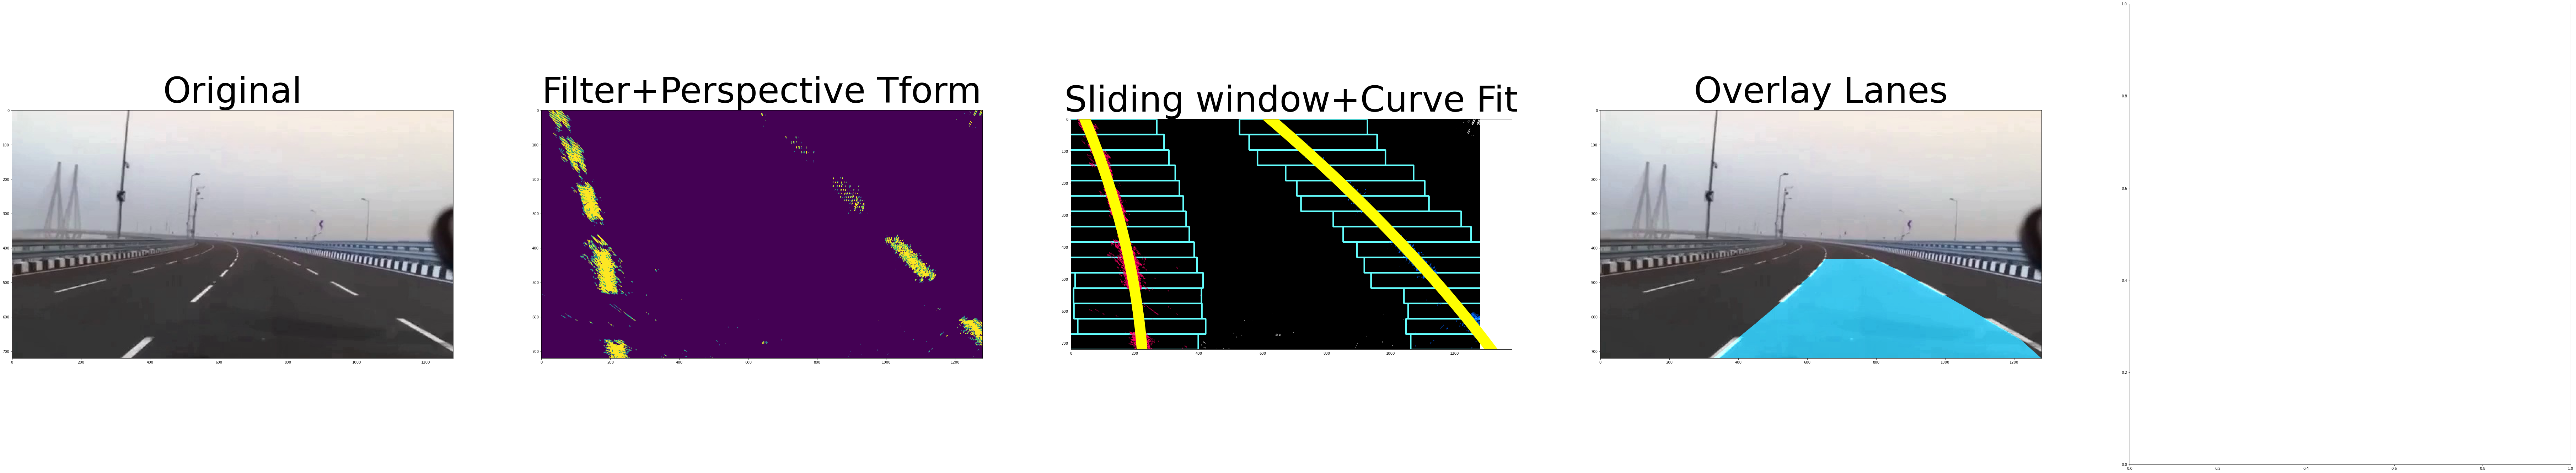

In [15]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(ln_img)
ax1.set_title('Original', fontsize=100)
ax2.imshow(combined)
ax2.set_title('Filter+Perspective Tform', fontsize=100)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100)
ax4.imshow(img_)

ax4.set_title('Overlay Lanes', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [16]:
vid3 = cv2.VideoCapture('Downtown.mp4')

In [17]:
if not vid3.isOpened():
    print('Could not Open')
else:
    frame_count3 = int(vid3.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width3 = int(vid3.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height3 = int(vid3.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps3 = int(vid3.get(cv2.CAP_PROP_FPS))
    pixels3 = frame_height3 * frame_width3
    
    print('Total frames:', frame_count3)
    print('NO. of Pixels in Each Frame:',  pixels3)
    print('width:', frame_width3)
    print('height:', frame_height3)
    print('fps:', fps3)

Total frames: 1342
NO. of Pixels in Each Frame: 230400
width: 640
height: 360
fps: 29


In [18]:
vid3_OP = 'ADVANCED_LANE_DETECTION.avi'
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out3 = cv2.VideoWriter(vid3_OP, fourcc, fps3, (1280, 720))

count = 0

while(vid3.isOpened()):
    
    ret, frame = vid3.read()
    
    if ret == True:
        frame = cv2.resize(frame, (1280, 720), interpolation = cv2.INTER_AREA)
        #plt.imshow(frame)
        #plt.show()
        warped = perspective_warp(frame)
        combined= combined_binary_threshold(warped, thresh=(100, 255), sob_thresh=(15, 255))
        out_img, curves, lanes, ploty = sliding_window(combined)
        #plt.imshow(out_img)
        #plt.plot(curves[0], ploty, color='yellow', linewidth=30)
        #plt.plot(curves[1], ploty, color='yellow', linewidth=30)
        #plt.show()
        curverad =get_curve(frame, curves[0], curves[1])
        img = draw_lanes(frame, curves[0], curves[1])
        out3.write(img)
        count += 1
        #print('count:',count)
        cv2.imshow('window', img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
vid3.release()
out3.release
cv2.destroyAllWindows() 